# Deteksi Outlier dengan K-Nearest Neighbors (KNN)

## 1. Mengapa KNN Bisa Digunakan untuk Deteksi Outlier?  
Metode K-Nearest Neighbors (KNN) bekerja dengan prinsip kedekatan antar data, sehingga dapat dimanfaatkan untuk mengidentifikasi outlier. Deteksi outlier menggunakan KNN umumnya didasarkan pada konsep berikut:

* Jika suatu titik data memiliki sedikit tetangga dalam jarak tertentu, kemungkinan besar titik tersebut adalah outlier.
* Jika rata-rata jarak titik data ke k tetangga terdekatnya cukup besar, maka data tersebut dapat dianggap sebagai outlier.

## 2. Langkah-Langkah Deteksi Outlier dengan KNN  
 1. Mengukur Jarak Antar Titik Data  
Jarak antar titik dihitung menggunakan metrik seperti Euclidean Distance, Manhattan Distance, atau Minkowski Distance untuk mengetahui seberapa dekat suatu data dengan yang lainnya.

 2. Menentukan nilai K (Jumlah Tetangga Terdekat)  
Pemilihan nilai K berpengaruh terhadap efektivitas outlier deteksi:
- Nilai K yang terlalu kecil dapat membuat model terlalu sensitif terhadap noise.  
- Nilai K yang terlalu besar bisa menyebabkan outlier tidak terdeteksi dengan baik.  

3. Menghitung Skor Kepadatan (Density Score)  
Beberapa metode untuk menilai apakah suatu titik merupakan outlier meliputi:
  * **K-Nearest Neighbor Distance** - Menghitung jarak rata-rata ke K tetangga terdekat. Jika jarak ini terlalu besar, maka titik tersebut dianggap sebagai outlier.
  * **Local Outlier Factor (LOF)** - Metode ini membandingkan kepadatan lokal suatu titik dengan kepadatan tetangganya. Jika kepadatan lokal suatu titik lebih rendah dibandingkan tetangganya, maka titik tersebut bisa dianggap sebagai outlier.  
  * **Distance-Based Outlier Score** - Jika sebuah titik memiliki jumlah tetangga yang sangat sedikit dalam radius tertentu, maka titik tersebut kemungkinan besar adalah outlier.

In [36]:
%pip install pymysql
%pip install psycopg2

In [37]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split , KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, Normalizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay

In [38]:
def get_pg_data():
    conn = psycopg2.connect(
        host="postgresqltest-projectadzin.i.aivencloud.com",
        user="avnadmin",
        password="AVNS_k58rpi0pi31N8ucX-vK",
        database="defaultdb",
        port=16209
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM sepal")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Ambil nama kolom
    cursor.close()
    conn.close()

    return pd.DataFrame(data, columns=columns)

def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-386c0068-projectadzin.l.aivencloud.com",
        user="avnadmin",
        password="AVNS_-Zr6_we8osFXobQb3qi",
        database="iris",
        port=16209
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM petal")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Ambil nama kolom
    cursor.close()
    conn.close()

    return pd.DataFrame(data, columns=columns)

# Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# Gabungkan berdasarkan kolom 'id' dan 'Class'
df_merged = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Ambil data fitur numerik
feature_columns = ["petal_length", "petal_width", "sepal_length", "sepal_width"]
data_values = df_merged[feature_columns].values

In [39]:
# KNN Outlier Detection
def knn_outlier_detection(data, k=90):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)
    avg_distances = distances[:, -1]  # Ambil jarak k-terjauh sebagai skor
    return avg_distances

# Hitung K-NN distance
df_merged["knn_distance"] = knn_outlier_detection(data_values, k=5)

# Tentukan threshold sebagai nilai rata-rata + 2 standar deviasi
threshold = df_merged["knn_distance"].mean() + 2 * df_merged["knn_distance"].std()
df_merged["outlier_knn"] = df_merged["knn_distance"] > threshold

# Hapus data outlier
df_filtered = df_merged[df_merged["outlier_knn"] != True]

# Cetak hasil setelah outlier dihapus
print(df_filtered.to_string(index=False))

print('\n')
num_outliers = df_merged["outlier_knn"].sum()
print(f"Jumlah Outlier: {num_outliers}")

 id           class  petal_length  petal_width  sepal_length  sepal_width  knn_distance  outlier_knn
  1     Iris-setosa           1.4          0.2           5.1          3.5      0.141421        False
  3     Iris-setosa           1.3          0.2           4.7          3.2      0.264575        False
  5     Iris-setosa           1.4          0.2           5.0          3.6      0.223607        False
  6     Iris-setosa           1.7          0.4           5.4          3.9      0.374166        False
  7     Iris-setosa           1.4          0.3           4.6          3.4      0.316228        False
  8     Iris-setosa           1.5          0.2           5.0          3.4      0.200000        False
  9     Iris-setosa           1.4          0.2           4.4          2.9      0.360555        False
 10     Iris-setosa           1.5          0.1           4.9          3.1      0.173205        False
 11     Iris-setosa           1.5          0.2           5.4          3.7      0.331662    

## **Memisahkan outlier dari data**

In [40]:
# Gabungkan berdasarkan kolom 'id' dan 'class'
df_merge = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Ambil data fitur numerik tanpa kolom 'class'
feature_columns = ["petal_length", "petal_width", "sepal_length", "sepal_width"]
data_values = df_merge[feature_columns].values

# Inisialisasi model LOF
clf = LocalOutlierFactor(n_neighbors=90)
label = clf.fit_predict(data_values)

# Tambahkan hasil label ke dataframe
df_merge["outlier_label"] = label

# Cetak hasil dengan ID dan class
print(df_merge.to_string(index=False))

num_outliers = (label == -1).sum()
print(f"\nJumlah outlier: {num_outliers}")
df_filtered = df_merge[label == 1].drop(columns=["outlier_label"], errors='ignore')
outliers = df_merge[label == -1].drop(columns=["outlier_label"], errors='ignore')
print("\nData Outlier:")
print(outliers.to_string(index=False))
print("\nJumlah data setelah dihapus : ",len(df_filtered))
print("\nData tidak outlier :")
print(df_filtered.to_string(index=False))

 id           class  petal_length  petal_width  sepal_length  sepal_width  outlier_label
  1     Iris-setosa           1.4          0.2           5.1          3.5              1
  2     Iris-setosa          14.0          2.0          40.9         30.0             -1
  3     Iris-setosa           1.3          0.2           4.7          3.2              1
  4     Iris-setosa          15.0         20.0          46.0         31.0             -1
  5     Iris-setosa           1.4          0.2           5.0          3.6              1
  6     Iris-setosa           1.7          0.4           5.4          3.9              1
  7     Iris-setosa           1.4          0.3           4.6          3.4              1
  8     Iris-setosa           1.5          0.2           5.0          3.4              1
  9     Iris-setosa           1.4          0.2           4.4          2.9              1
 10     Iris-setosa           1.5          0.1           4.9          3.1              1
 11     Iris-setosa  

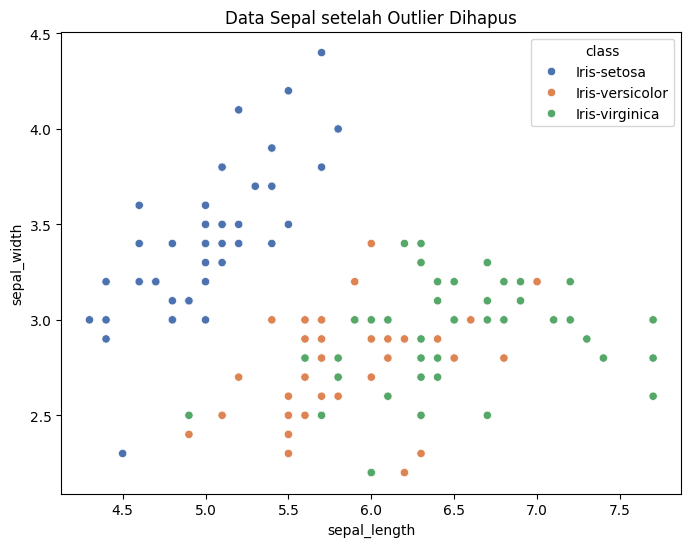

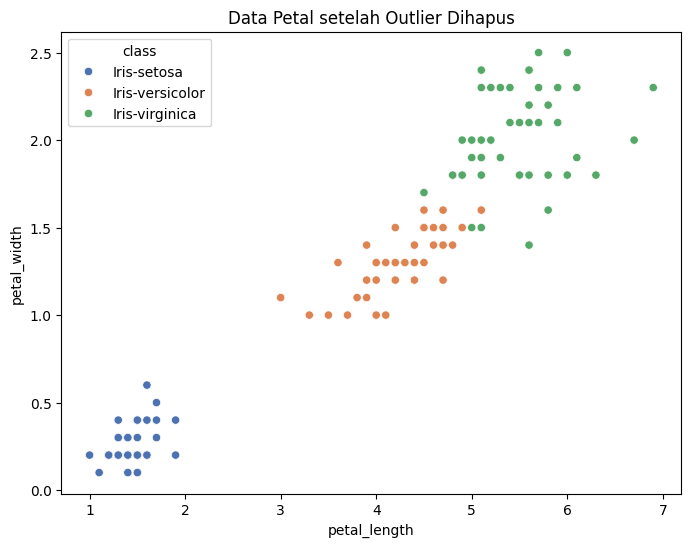

In [42]:
# Visualisasi setelah outlier dihapus
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_filtered["sepal_length"], y=df_filtered["sepal_width"],
    hue=df_filtered["class"], palette="deep"
)
plt.title("Data Sepal setelah Outlier Dihapus")
plt.show()
print('\n')
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_filtered["petal_length"], y=df_filtered["petal_width"],
    hue=df_filtered["class"], palette="deep"
)
plt.title("Data Petal setelah Outlier Dihapus")
plt.show()

## **Menghitung Akurasi dari data**

In [43]:
X = df_merged[feature_columns]
y = df_merged["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Menerapkan LOF untuk deteksi outlier
lof = LocalOutlierFactor(n_neighbors=90, contamination=0.1)
outlier_labels = lof.fit_predict(X)
df_merged["outlier"] = outlier_labels

# Pisahkan data dengan outlier dan tanpa outlier
df_cleaned = df_merged[df_merged["outlier"] == 1].drop(columns=["outlier"])

# Membagi data menjadi training (80%) dan testing (20%)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    df_cleaned[feature_columns],
    label_encoder.transform(df_cleaned["class"]),
    test_size=0.2,
    random_state=42
)

# Pipeline dengan StandardScaler dan KNN
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Latih model pada data dengan outlier
knn_pipeline.fit(X_train_all, y_train_all)
y_pred_all = knn_pipeline.predict(X_test_all)
accuracy_all = accuracy_score(y_test_all, y_pred_all)
print("Akurasi dengan outlier:", accuracy_all)
print(classification_report(y_test_all, y_pred_all, target_names=label_encoder.classes_))

# Latih model pada data tanpa outlier
knn_pipeline.fit(X_train_clean, y_train_clean)
y_pred_clean = knn_pipeline.predict(X_test_clean)
accuracy_clean = accuracy_score(y_test_clean, y_pred_clean)
print("Akurasi tanpa outlier:", accuracy_clean)
print(classification_report(y_test_clean, y_pred_clean, target_names=label_encoder.classes_))

Akurasi dengan outlier: 0.9666666666666667
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      1.00      0.95         9
 Iris-virginica       1.00      0.91      0.95        11

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30

Akurasi tanpa outlier: 1.0
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       1.00      1.00      1.00         7
 Iris-virginica       1.00      1.00      1.00         8

       accuracy                           1.00        27
      macro avg       1.00      1.00      1.00        27
   weighted avg       1.00      1.00      1.00        27

